#### 0. Import required libraries

In [267]:
import math
import numpy
from matplotlib import pyplot
import sympy  # Used for solving symbolic expressions
from potentialflowvisualizer import *

%matplotlib inline

#### 1. Create the NACA airfoil 

First step is to define the geometries of the NACA airfoil. The following cell defines the function to create the cambert line of a four digit NACA airfoil using two parabolas. Furthar, the thickness is used to define the upper and lower surfaces of teh airfoil. Points are alos plotted from a data base of the airfoils to verify if the plotted airfoil is the correct one.

In [268]:
# Function to create a NACA 4 digit airfoil.

def naca4(NACA="4412", n = 100):
    """
    Plots a 4 digit NACA airfoil given a 4 digit input string
    inputs: the four-digit NACA airfoil number
            : n = number of the chordwise points on the airfoil.
    """
    m = float(NACA[0])/100
    p = float(NACA[1])/10
    t = float(NACA[2:])/100
    
    if m == 0:
        print(f"NACA {NACA} is a symmetric airfoil, with a thickness of {t:1.1f}")
    else:
        print(f"NACA {NACA} has a max camber of {m:1.3f}, at {p:1.2f}, with a thickness of {t:1.1f}")

    x = numpy.linspace(0, 1, n)

    def camberline(x, m, p):
        y_c = numpy.zeros(x.shape)      # This function initiates the array/matrix to zero
        y_c[x<p] = m * x[x<p] / p**2 * (2*p - x[x<p])
        y_c[x>=p] = m * (1 - x[x>=p]) / (1 - p)**2 *(1 + x[x>=p] - 2*p)
        return y_c
    y_c = camberline(x, m, p)

    def theta_func(x, m, p):
        if m > 0:
            dzdx = numpy.zeros(x.shape)
            dzdx[x<p] = 2*m / p**2 * (p - x[x<p])
            dzdx[x>=p] = 2*m / (1-p)**2 * (p - x[x>=p])
            theta = numpy.arctan(dzdx)
        else:
            theta = 0
        return theta
    theta = theta_func(x, m, p)
    
    # We need the thickness so we write the coefficients first
    a0 = 0.2969
    a1 = -0.126
    a2 = -0.3516
    a3 = 0.2843
    a4 = -0.1036
    y_t = 5 * t * (a0*x**0.5 + a1*x + a2 * x**2 + a3*x**3 + a4*x**4)
   
    x_u = x - y_t*numpy.sin(theta)
    x_l = numpy.flip(x + y_t*numpy.sin(theta))

    y_u = y_c + y_t*numpy.cos(theta)
    y_l = numpy.flip(y_c - y_t*numpy.cos(theta))
 
    # Export to a single file to plot and discretize
    surf_x = numpy.concatenate((x_u, x_l))
    surf_y = numpy.concatenate((y_u, y_l))

    data = np.array([x, y_c]).T
    np.savetxt('camberline.txt', data, fmt='%.4f', delimiter='\t')
    
    fig, ax = pyplot.subplots(1, 2, figsize = (16, 4))
    ax[0].plot(x, y_c, '-b')
    ax[0].plot(x_u, y_u, '-r')
    ax[0].plot(x_l, y_l, '-g')
    ax[0].set_title('NACA ' + str(int(m * 100)) + str(int(p * 10)) + str(int(t * 100)) + ' plot for Thin Airfoil Theory')
    ax[0].set_ylim([-0.2, 0.2])
    ax[1].plot(surf_x, surf_y)
    ax[1].set_title('NACA ' + str(int(m * 100)) + str(int(p * 10)) + str(int(t * 100)) + ' plot for Vortex Panel Method')
    ax[1].set_ylim([-0.2, 0.2])
    pyplot.savefig('figure.eps', format='eps')
    return surf_x, surf_y, m, p, theta, x_u


##### 1.1 Plot the airfoil
Using the functions above, plot the camberline and the airfoil upper and lower surfaces.

NACA 4412 has a max camber of 0.040, at 0.40, with a thickness of 0.1


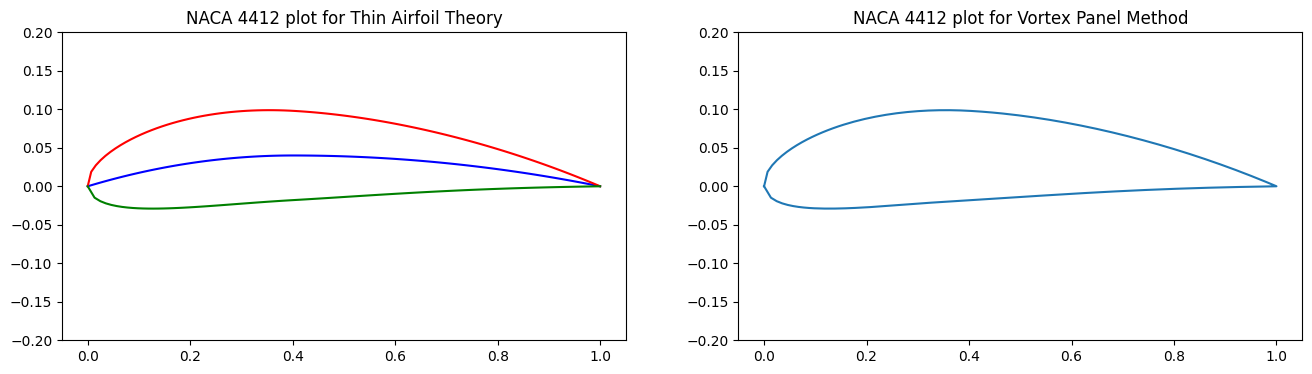

In [269]:
naca_x, naca_y, m, p, theta_input, x_u = naca4("4412");
#pyplot.savefig('destination_path.eps', format='eps')

## Define all input parameter in this block

In [270]:
alpha = 1                   # [deg]
c = 1                       # Chord length [m]
b = 8                       # Wingspan [m]
U_inf = 146                 # [m/s]
rho_inf = 1.225 


## Vortex Panel Method

#### 2. Defining the panels
##### 2.1 How are streamlines formed?

To satisfy the condition that the surface of the airfoil should be a strealine is satisfied by equatiing the normal component of velocity to zero at the control points throughout the geometry.

$$
\phi\left(x_i, y_i\right)=-\sum_{j=1}^n \frac{\gamma_j}{2 \pi} \int_j \theta_{i j} d s_j
$$

In [271]:
def centre_points(naca_x, naca_y):
    n = numpy.shape(naca_x)[0] - 1
    centres = numpy.zeros((n, 2))
    for i in range(0, n):
        centres[i, 0] = 0.5 * (naca_x[i] + naca_x[i + 1])
        centres[i, 1] = 0.5 * (naca_y[i] + naca_y[i + 1])
    pyplot.scatter(naca_x, naca_y)
    pyplot.plot(naca_x, naca_y)
    return n, centres

(199,
 array([[ 3.41269102e-03,  9.39856944e-03],
        [ 1.13021852e-02,  2.30135052e-02],
        [ 2.04480490e-02,  3.05579450e-02],
        [ 2.98920789e-02,  3.67333477e-02],
        [ 3.95134318e-02,  4.21051854e-02],
        [ 4.92593468e-02,  4.69124790e-02],
        [ 5.91003313e-02,  5.12846097e-02],
        [ 6.90175776e-02,  5.53014250e-02],
        [ 7.89980348e-02,  5.90165084e-02],
        [ 8.90320909e-02,  6.24680012e-02],
        [ 9.91123453e-02,  6.56842767e-02],
        [ 1.09232900e-01,  6.86871799e-02],
        [ 1.19388924e-01,  7.14940026e-02],
        [ 1.29576369e-01,  7.41187485e-02],
        [ 1.39791782e-01,  7.65729792e-02],
        [ 1.50032169e-01,  7.88663981e-02],
        [ 1.60294900e-01,  8.10072657e-02],
        [ 1.70577642e-01,  8.30027022e-02],
        [ 1.80878301e-01,  8.48589127e-02],
        [ 1.91194987e-01,  8.65813578e-02],
        [ 2.01525976e-01,  8.81748846e-02],
        [ 2.11869691e-01,  8.96438299e-02],
        [ 2.22224681e-01, 

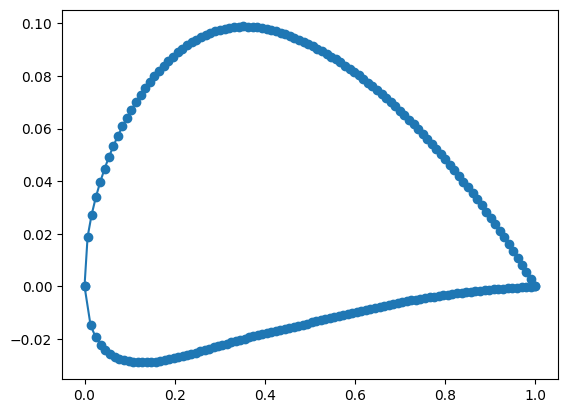

In [272]:
centre_points(naca_x, naca_y)

In [273]:
def panels(naca_x, naca_y, N=30):
    """
    Cosine method to discretize the geometry into panels
    
    Inputs__>
    naca_x: x coordinate to the naca4 airfoil
    naca_y: corresponding y coordinate of the naca4 airfoil
    N: number of panels to be discretized to.

    Returns__>
    panels: numpy array of all the panels created using the function

    Methodology adopted from "https://github.com/barbagroup/AeroPython"    

    """
    
    # Using maximum and minimum x coordinates to create a circle around the airfoil

    R = (naca_x.max() - naca_x.min())/2             # Radius of the circle
    centre_x = (naca_x.max() + naca_x.min())/2      # Coordinate of the radius of the circle in x

    panel_angle = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)      # Create an array of angles
    circle_x =  centre_x + R * numpy.cos(panel_angle)             # x_coordiante of the circle

    x_ends = numpy.copy(circle_x)
    y_ends = numpy.empty_like(x_ends)       # Create and empty array to fill using the x-coordinates

    # Since the airfoil is a closed surface, an extra point is to be appended to compute the centres at all points.
    # naca_x, naca_y = numpy.append(naca_x, naca_x[0]), numpy.append(naca_y, naca_y[0])

## Thin Airfoil Theory

In [274]:
def thin_airfoil(m, p, theta, alpha):

    """
    This function calculates for cl, angle of zero lift and pitching moment using thin airfoil theory
    
    """
    c = 1
    n = 1
    alpha = alpha *(numpy.pi) / 180

    # Sympy Operations
    x = sympy.symbols('x')
    theta = sympy.symbols('theta')


    # Converting x to theta and evaluating p_break in radians
    x = (c / 2) * (1 - sympy.cos(theta))
    p_break = sympy.acos(1 - (2*p/c))

    
    # NON SYMMETRIC AIRFOIL
    if m > 0:
        # Camber_functions as functions of theta
        camber_function_1 = (2 * m / p**2) * (p - x)               # for x < p
        camber_function_2 = (2 * m/ (1 - p)**2) * (p - x)          # for x >= p
    
        A_0 = alpha - (1 / numpy.pi) *  ((sympy.integrate(camber_function_1, (theta, 0, p_break)))\
                                         +(sympy.integrate(camber_function_2, (theta, p_break, numpy.pi))))
        
        A_1 = (2 / numpy.pi) *((sympy.integrate(camber_function_1 * sympy.cos(n * theta), (theta, 0, p_break)))\
                               +(sympy.integrate(camber_function_2 * sympy.cos(n * theta), (theta, p_break, numpy.pi))))
        
        A_2 = (2 / numpy.pi) *((sympy.integrate(camber_function_1 * sympy.cos(2 * theta), (theta , 0, p_break)))\
                               +(sympy.integrate(camber_function_2 * sympy.cos(2 * theta), (theta, p_break, numpy.pi))))
        
        c_l = 2 * numpy.pi * (A_0 + (A_1 / 2))
        c_l = sympy.simplify(c_l)
        c_m = ((numpy.pi)/4)*(A_2 - A_1)
        alpha_lift_0 = (-1/numpy.pi) *     (   (sympy.integrate(camber_function_1 * (sympy.cos(theta) - 1), (theta, 0, p_break)))   +   (sympy.integrate(camber_function_2 * (sympy.cos(theta) - 1), (theta, p_break, numpy.pi)))   ) * (180/numpy.pi)
        x_cp = (1/4) * (1 + ((numpy.pi) / c_l) * (A_1 - A_2))


        
    # SYMMETRIC AIRFOIL
    else:
        c_l = 2 * numpy.pi * alpha
        alpha_lift_0 = 0
        gamma = 2 * alpha * ((1 + numpy.cos(theta_input))/ numpy.sin(theta_input))

    return c_l, alpha_lift_0, c_m, x_cp

a, alpha_lift_0, c_m, x_cp = thin_airfoil(m, p, theta_input, alpha)
print(c_m)


-0.106239026920182


## Finite Wing Theory: Monoplane Equation

In [275]:
from py2fly import finite_wing, drag_polar

Aspect Ratio:  8.00000000000000
Taper Ratio: 1
Wing Area:  8.00000000000000
Lift Coefficient:  0.435212739870788
Drag Coefficient:  0.00804593635117457
Induced Drag Factor:  0.06761152311253808
Oswald Efficiency Factor:  0.9366702947197292


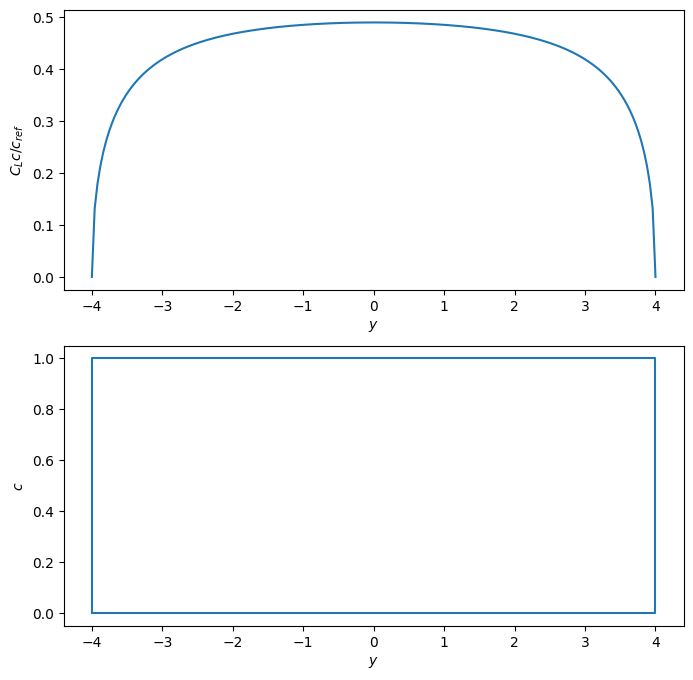

In [276]:
# Define the input parameters
N = 20  # Number of terms in the expansion

# Call the finite wing function
finite_wing(b, c, alpha_lift_0, alpha, N, True);
#drag_polar(b, c, alpha_lift_0, N);